By Drilon & Chia-Hua

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [4]:
import pandas as pd
df = pd.read_csv("./Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()
df.describe()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


#### Normalization and Turning into Torch Tensors

In [5]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [7]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)

In [16]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    if X.dim() == 1:  # Check if X is a vector otherwise i get an error with the test
        X = X.unsqueeze(0)
    z = torch.mm(X, W.t())
    sigm = 1 / (1 + torch.exp(-z))
    return sigm
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    yhat = predict(X, W)
    eps = 1e-5  # Small value to avoid log(0)
    return -torch.mean(Y * torch.log(yhat + eps) + (1 - Y) * torch.log(1 - yhat + eps))
    # YOUR CODE (END)

In [17]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    yhat = predict(X, W)
    return torch.mm((yhat - Y).t(), X) / X.size(0)
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    pred = (Yhat >= 0.5).float()
    corr = (pred == Y).float().sum()
    return corr / Y.size(0)
    # YOUR CODE (END)

Just for testing:

In [19]:
W = torch.randn((1,14), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([[0.7129]], dtype=torch.float64)
tensor(1.1848, dtype=torch.float64)
tensor([[-0.0757, -0.0757, -0.0309, -0.0230, -0.0315, -0.0225,  0.0491, -0.1085,
         -0.0668,  0.1549, -0.0369, -0.2400, -0.1138,  0.1219]],
       dtype=torch.float64)
tensor(0.6097)


### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.870968, 0.854839
Training Cost (end): 0.284106


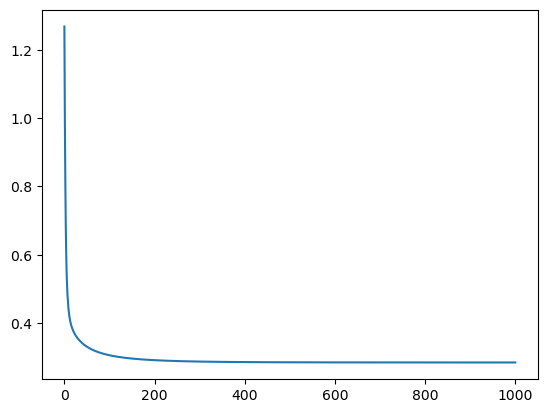

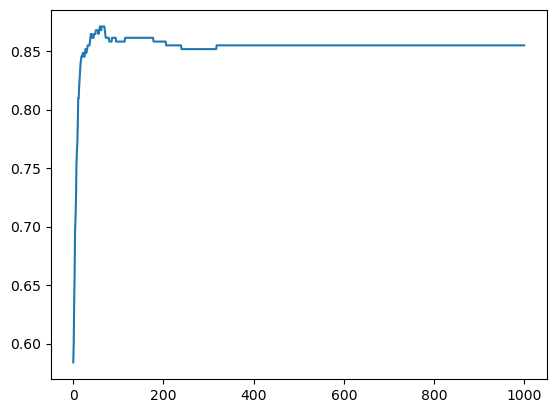

In [21]:
# adjust if needed
nepochs = 1000
lr = 1.0

## initial parameter
W = torch.randn((1,14), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    grad = gradient_cost(X, Y, W)
    W -= lr * grad
    costs.append(cost(X,Y,W))
    accs.append(accuracy(Y,predict(X,W)))

accs = np.array(accs)
# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.plot(range(nepochs+1),accs)

### 4. Implement Full Batch Gradient Descent with PyTorch's autograd

Training Accuracy with autograd (max,end): 0.870968, 0.854839
Training Cost with autograd (end): 0.284107


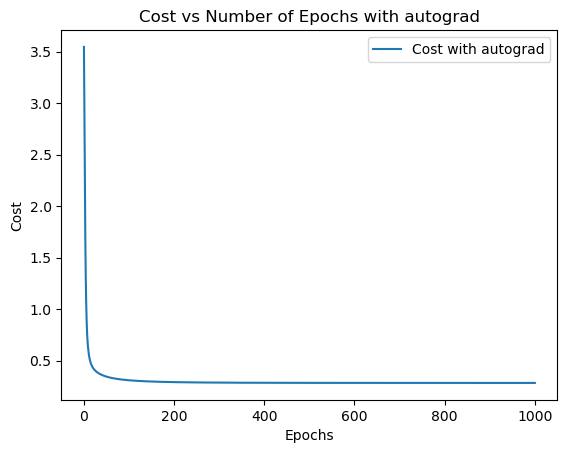

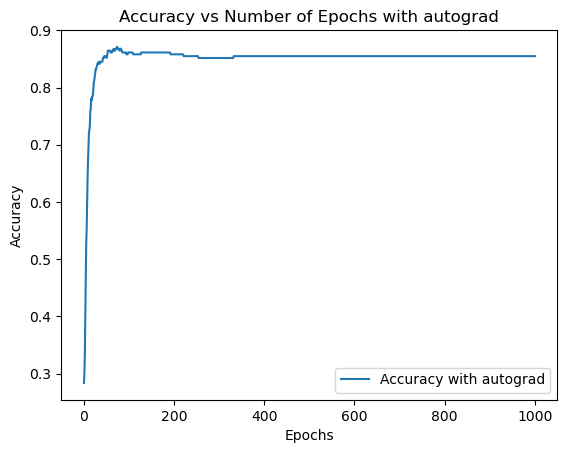

In [23]:
nepochs_autograd = 1000

lr_autograd = 1.0
W_autograd = torch.randn((1, 14), dtype=torch.double, requires_grad=True)

costs_autograd = [cost(X, Y, W_autograd).item()]
accs_autograd = [accuracy(Y, predict(X, W_autograd)).item()]

for epoch in range(nepochs_autograd):
    W_autograd.grad = None 
    cost_value = cost(X, Y, W_autograd)
    cost_value.backward()

    with torch.no_grad():
        W_autograd -= lr_autograd * W_autograd.grad
    costs_autograd.append(cost(X, Y, W_autograd).item())
    accs_autograd.append(accuracy(Y, predict(X, W_autograd)).item())

accs_autograd = np.array(accs_autograd)

print("Training Accuracy with autograd (max,end): %f, %f" % (np.max(accs_autograd), accs_autograd[-1]))
print("Training Cost with autograd (end): %f" % costs_autograd[-1])
plt.figure(1)

plt.plot(range(nepochs_autograd + 1), costs_autograd, label="Cost with autograd")
plt.title("Cost vs Number of Epochs with autograd")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()


plt.figure(2)
plt.plot(range(nepochs_autograd + 1), accs_autograd, label="Accuracy with autograd")
plt.title("Accuracy vs Number of Epochs with autograd")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.show()

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

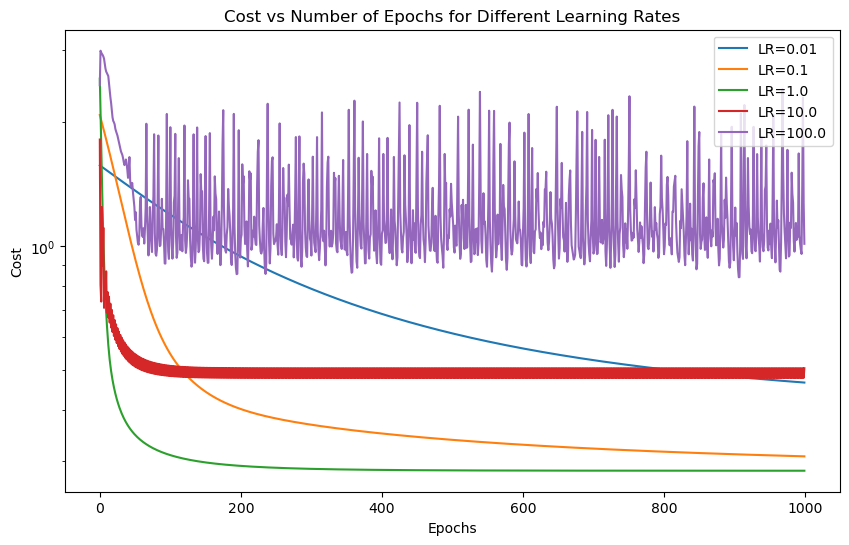

In [25]:
# Experiment with different learning rates
learning_rates = [0.01, 0.1, 1.0, 10.0, 100.0]
nepochs_lr = 1000
results = {}

for lr in learning_rates:
    W_lr = torch.randn((1, 14), dtype=torch.double, requires_grad=True)
    costs_lr = []

    for epoch in range(nepochs_lr):
        W_lr.grad = None
        cost_value = cost(X, Y, W_lr)
        cost_value.backward()
        with torch.no_grad():
            W_lr -= lr * W_lr.grad
        costs_lr.append(cost_value.item())
    results[lr] = costs_lr

# plotting the cost vs epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, costs_lr in results.items():
    plt.plot(range(nepochs_lr), costs_lr, label=f"LR={lr}")

plt.title("Cost vs Number of Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.yscale("log")
plt.legend()
plt.show()

- **Learning Rate = 0.01 and 0.1**: These lower rates make learning slow but steady. The cost goes down over time, but it might take longer to get to the lowest cost. These are safe choices because they're stable but slow.

- **Learning Rate = 1.0**: This rate is good because it makes the cost go down quickly at first. It's a good mix of being fast and stable, which fits this model well.

- **Learning Rate = 10.0**: This rate could work but is very close to being too high. It might get to a good point if the model allows, but it could also be unstable and miss the lowest cost.

- **Learning Rate = 100.0**: This very high rate doesn't work well. The cost doesn't go down in a controlled way, showing the rate is too high. It can make the model miss the lowest cost completely, not getting better.